# EDA on WB & IRENA merged dataframe

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Uploading main energy dataframe:

In [5]:
df = pd.read_csv('/Users/valentinereltien/Desktop/Capstone Project/Energy_df2.csv')

In [6]:
df.columns

Index(['Country', 'Project', 'Date', 'Investor', 'Technology', 'Asset Class',
       'Invested_USDM', 'Source', 'gdp_g_anpc', 'AdjSav_pcGNI', 'gni_g_anpc',
       'AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd', 'AdjSav_Ptcldmg_pcGNI',
       'Pvt_inv_USDM', 'Unemp_pcLF', 'CO2ems_mTpCpt'],
      dtype='object')

In [7]:
df.shape

(7178, 17)

Adding the Adjusted Savings feature given as US dollars vs % of GNI as they presently figure. It occurred to me leaving them as such might cause too much correlation within the df.

In [8]:
Adjsavs_usd = pd.read_csv('/Users/valentinereltien/Desktop/IRENA/Wb_adjsavusd.csv')
Adjsavs_usd.head()

,Country,Date,Adjusted savings: net national savings (current US$)
0,Afghanistan,2009-01-01,-1822609495.08428
1,Afghanistan,2010-01-01,-2368530527.05617
2,Afghanistan,2011-01-01,-1956679871.5834
3,Afghanistan,2012-01-01,-194013007.599192
4,Afghanistan,2013-01-01,1310040622.78426


In [9]:
Adjsavs_usd.rename(columns = {'Adjusted savings: net national savings (current US$)': 'AdjNetNatSv_usd'}, inplace=True)
df2 = pd.merge(df, Adjsavs_usd, on = ['Country', 'Date'], how = 'left')

In [10]:
df2.columns

Index(['Country', 'Project', 'Date', 'Investor', 'Technology', 'Asset Class',
       'Invested_USDM', 'Source', 'gdp_g_anpc', 'AdjSav_pcGNI', 'gni_g_anpc',
       'AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd', 'AdjSav_Ptcldmg_pcGNI',
       'Pvt_inv_USDM', 'Unemp_pcLF', 'CO2ems_mTpCpt', 'AdjNetNatSv_usd'],
      dtype='object')

Checking null values in order to clean the now complete dataframe:

In [11]:
df2.isnull().sum()


Country                    0
Project                    0
Date                       0
Investor                   0
Technology                 0
Asset Class                0
Invested_USDM              0
Source                     0
gdp_g_anpc                 0
AdjSav_pcGNI             574
gni_g_anpc               665
AdjSav_Engdep_usd         28
AdjSav_CO2dmg_usd         46
AdjSav_Ptcldmg_pcGNI     113
Pvt_inv_USDM            3357
Unemp_pcLF                62
CO2ems_mTpCpt           2399
AdjNetNatSv_usd          576
dtype: int64

Transforming columns values into float to ready for the below imputing loop covering missing features: 

In [12]:
df2.AdjNetNatSv_usd = df2.AdjNetNatSv_usd.map(lambda x: float(x))

In [13]:
for ind, col in enumerate(df2.loc[:,'gni_g_anpc':]):
    print(ind, col)
    df2.groupby('Country')[col].transform(lambda x: x.fillna(x.mean()))

0 gni_g_anpc
1 AdjSav_Engdep_usd
2 AdjSav_CO2dmg_usd
3 AdjSav_Ptcldmg_pcGNI
4 Pvt_inv_USDM
5 Unemp_pcLF
6 CO2ems_mTpCpt
7 AdjNetNatSv_usd


Saving as csv for future re-use:

In [14]:
df2.to_csv('CSdf_3.csv', index=False)

Splitting frame into predictors and target to start basic EDA: 

In [30]:
X = df.copy()

In [31]:
y = X.pop('Invested_USDM')

In [32]:
y.value_counts()

0.1000     28
0.1024     23
0.0112     19
0.0111     17
0.0034     16
           ..
0.7062      1
6.8442      1
30.4233     1
0.8073      1
1.2163      1
Name: Invested_USDM, Length: 4940, dtype: int64

Using Groupby for initial investigation. 
First, figuring which countries are most likely to receive funding:

In [33]:
df.groupby('Country')[['Invested_USDM']].count().sort_values(by='Invested_USDM', ascending=False)

,Invested_USDM
Country,
Brazil,779
India,383
China,240
Indonesia,181
Kenya,175
...,...
Eswatini,2
Cyprus,1
Lithuania,1


Which technologies receive most funding: 

In [34]:
df.groupby('Technology')[['Invested_USDM']].count().sort_values(by='Invested_USDM', ascending=False)

,Invested_USDM
Technology,
Multiple renewables*,2741
Solar energy,1590
Renewable Hydropower,1084
Wind energy,857
Bioenergy,634
Geothermal energy,206
Other renewable energy,56
Marine energy,10


In [35]:
df.Invested_USDM.value_counts().normalize=True

Visualizing the relationship between Adjusted Savings based on which emission the measure includes:

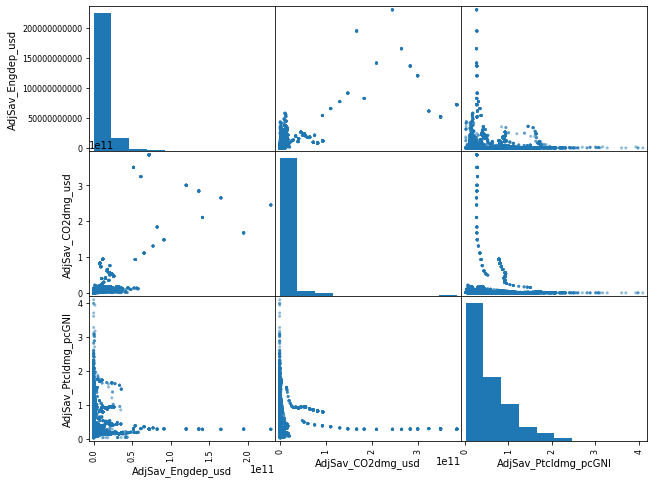

In [11]:
pd.plotting.scatter_matrix(X[['AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd', 'AdjSav_Ptcldmg_pcGNI']], figsize=(10, 8));

In [36]:
X.isnull().sum()

Country                    0
Project                    0
Date                       0
Investor                   0
Technology                 0
Asset Class                0
Source                     0
gdp_g_anpc                 0
AdjSav_pcGNI             574
gni_g_anpc               665
AdjSav_Engdep_usd         28
AdjSav_CO2dmg_usd         46
AdjSav_Ptcldmg_pcGNI     113
Pvt_inv_USDM            3357
Unemp_pcLF                62
CO2ems_mTpCpt           2399
dtype: int64

In [37]:
X.shape[0]/4

1794.5

Based on this observation, I decide to drop features with close to a 1/4 missing values:

In [38]:
X.drop('Pvt_inv_USDM', axis=1, inplace=True)

In [39]:
X.shape

(7178, 15)

In [40]:
X.dtypes

Country                  object
Project                  object
Date                     object
Investor                 object
Technology               object
Asset Class              object
Source                   object
gdp_g_anpc              float64
AdjSav_pcGNI            float64
gni_g_anpc              float64
AdjSav_Engdep_usd       float64
AdjSav_CO2dmg_usd       float64
AdjSav_Ptcldmg_pcGNI    float64
Unemp_pcLF              float64
CO2ems_mTpCpt           float64
dtype: object

In [41]:
X['Asset Class'].nunique()

9

In [42]:
X.isnull().sum()

Country                    0
Project                    0
Date                       0
Investor                   0
Technology                 0
Asset Class                0
Source                     0
gdp_g_anpc                 0
AdjSav_pcGNI             574
gni_g_anpc               665
AdjSav_Engdep_usd         28
AdjSav_CO2dmg_usd         46
AdjSav_Ptcldmg_pcGNI     113
Unemp_pcLF                62
CO2ems_mTpCpt           2399
dtype: int64

Adding the newly measured Adjusted Saving feature (Vs that in % of GNI)

In [43]:
Adjsavs_usd.rename(columns = {'Adjusted savings: net national savings (current US$)': 'AdjNetNatSv_usd'}, inplace=True)

I first experiment with a dataframe leaving out all missing values:

In [44]:
df2_nona = pd.merge(df, Adjsavs_usd, on = ['Country', 'Date'], how = 'left')

In [45]:
df2 = df2[df2.Date >= '2000-01-01']
df2.shape

(7178, 18)

In [46]:
df2_nona = df2_nona[df2_nona.Date >= '2000-01-01']
df2_nona.shape
df2_nona.columns

Index(['Country', 'Project', 'Date', 'Investor', 'Technology', 'Asset Class',
       'Invested_USDM', 'Source', 'gdp_g_anpc', 'AdjSav_pcGNI', 'gni_g_anpc',
       'AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd', 'AdjSav_Ptcldmg_pcGNI',
       'Pvt_inv_USDM', 'Unemp_pcLF', 'CO2ems_mTpCpt', 'AdjNetNatSv_usd'],
      dtype='object')

Eventually I decide to start more research with this dataframe:

In [47]:

df3 = df2_nona.copy()

Explore different classes in several features, enquiring weather I could dummify or encode them for modelling: 

In [48]:
df3['Asset Class'].value_counts()

Grant                                       4707
Loan                                        1809
Other Official Flows (non Export Credit)     494
Equity Investment                            104
Private Development Finance                   33
Insurance                                     13
Guarantee                                     10
Credit line                                    7
Bond                                           1
Name: Asset Class, dtype: int64

In [49]:
df3.Technology.value_counts()

Multiple renewables*      2741
Solar energy              1590
Renewable Hydropower      1084
Wind energy                857
Bioenergy                  634
Geothermal energy          206
Other renewable energy      56
Marine energy               10
Name: Technology, dtype: int64

Clean Technology column:

In [50]:
df3.Technology = df3.Technology.apply(lambda x: x.replace('*', ''))

In [51]:
df3.isnull().sum(), df3.shape

(Country                    0
 Project                    0
 Date                       0
 Investor                   0
 Technology                 0
 Asset Class                0
 Invested_USDM              0
 Source                     0
 gdp_g_anpc                 0
 AdjSav_pcGNI             574
 gni_g_anpc               665
 AdjSav_Engdep_usd         28
 AdjSav_CO2dmg_usd         46
 AdjSav_Ptcldmg_pcGNI     113
 Pvt_inv_USDM            3357
 Unemp_pcLF                62
 CO2ems_mTpCpt           2399
 AdjNetNatSv_usd          576
 dtype: int64, (7178, 18))

Given quantity of missing values, I collect private investment & CO2_emissions column though I drop from overall DF:

In [52]:
pvt_inv = df3.Pvt_inv_USDM
CO2_ems = df3.CO2ems_mTpCpt

In [53]:
df3.drop(['Pvt_inv_USDM', 'CO2ems_mTpCpt'], axis=1, inplace=True)

Also drop Adjusted Savings as % of GNI, replace with AdjNetNatSv_usd (current $):

In [54]:

df3.drop('AdjSav_pcGNI', axis=1, inplace=True)

This is telling me 30 countries may provide nearly 4500 rows of data

In [80]:

df3.Country.value_counts().sort_values(ascending=False)[:30].sum()

4498

In [81]:
#Below, calculating what would result from dropping all null data: Results in 6000 rows.... Shall I go w/ this?
df3.dropna().shape

(6176, 15)

In [82]:
df_nona = df3.dropna()

In [83]:
df_nona.isnull().sum()

Country                 0
Project                 0
Date                    0
Investor                0
Technology              0
Asset Class             0
Invested_USDM           0
Source                  0
gdp_g_anpc              0
gni_g_anpc              0
AdjSav_Engdep_usd       0
AdjSav_CO2dmg_usd       0
AdjSav_Ptcldmg_pcGNI    0
Unemp_pcLF              0
AdjNetNatSv_usd         0
dtype: int64

In [85]:
df_nona.to_csv('CSdf_nona.csv', index=False)

In [73]:
#Attending GNI growth as annual %: Below list of countries w/ missing gni_g: 
df3[df3.gni_g_anpc.isnull()].groupby('Country').count()

#Issue is that they do contain other measures. I'm therefore reluctant to remove it

,Project,Date,Investor,Technology,Asset Class,Invested_USDM,Source,gdp_g_anpc,gni_g_anpc,AdjSav_Engdep_usd,AdjSav_CO2dmg_usd,AdjSav_Ptcldmg_pcGNI,Unemp_pcLF,AdjNetNatSv_usd
Country,,,,,,,,,,,,,,
Afghanistan,100,100,100,100,100,100,100,100,0,100,100,79,100,79
Albania,9,9,9,9,9,9,9,9,0,9,9,9,9,9
Azerbaijan,5,5,5,5,5,5,5,5,0,5,5,5,5,5
Barbados,2,2,2,2,2,2,2,2,0,2,2,2,2,0
Bhutan,3,3,3,3,3,3,3,3,0,3,3,3,3,0
Cabo Verde,2,2,2,2,2,2,2,2,0,2,2,2,2,0
Chad,1,1,1,1,1,1,1,1,0,1,1,1,1,0
Cuba,10,10,10,10,10,10,10,10,0,10,10,0,10,0
Dominica,5,5,5,5,5,5,5,5,0,5,5,0,0,0


In [94]:
df3.Country.value_counts().unique()

array([779, 383, 240, 181, 175, 174, 160, 153, 147, 132, 128, 123, 116,
       112, 109, 106, 105, 100,  95,  92,  89,  88,  86,  81,  78,  77,
        75,  74,  72,  71,  69,  68,  67,  64,  63,  62,  61,  58,  56,
        55,  51,  50,  45,  44,  43,  42,  41,  40,  39,  36,  34,  33,
        32,  31,  30,  27,  26,  25,  24,  23,  22,  21,  19,  18,  17,
        16,  15,  14,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,
         2,   1])

In [59]:
#I have values for 136 countries: how many for each? 
df3.groupby('Country').count()

,Project,Date,Investor,Technology,Asset Class,Invested_USDM,Source,gdp_g_anpc,gni_g_anpc,AdjSav_Engdep_usd,AdjSav_CO2dmg_usd,AdjSav_Ptcldmg_pcGNI,Unemp_pcLF,AdjNetNatSv_usd
Country,,,,,,,,,,,,,,
Afghanistan,100,100,100,100,100,100,100,100,0,100,100,79,100,79
Albania,26,26,26,26,26,26,26,26,17,26,26,26,26,26
Algeria,32,32,32,32,32,32,32,32,32,32,32,32,32,24
Angola,16,16,16,16,16,16,16,16,16,16,16,16,16,16
Argentina,95,95,95,95,95,95,95,95,95,95,95,95,95,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,36,36,36,36,36,36,36,36,36,36,36,36,36,36
Uzbekistan,16,16,16,16,16,16,16,16,1,16,16,16,16,0
Vanuatu,22,22,22,22,22,22,22,22,11,22,22,22,22,11


In [63]:
#Is the below saying that I have these many values per country, on average? 
df3.groupby('Country').count().mean()

Project                 52.779412
Date                    52.779412
Investor                52.779412
Technology              52.779412
Asset Class             52.779412
Invested_USDM           52.779412
Source                  52.779412
gdp_g_anpc              52.779412
gni_g_anpc              47.889706
AdjSav_Engdep_usd       52.573529
AdjSav_CO2dmg_usd       52.441176
AdjSav_Ptcldmg_pcGNI    51.948529
Unemp_pcLF              52.323529
AdjNetNatSv_usd         48.544118
dtype: float64

In [70]:
df3.groupby('Country').sum().mean()

gdp_g_anpc              2.282023e+02
gni_g_anpc              2.021937e+02
AdjSav_Engdep_usd       4.393649e+11
AdjSav_CO2dmg_usd       7.337827e+11
AdjSav_Ptcldmg_pcGNI    3.001952e+01
Unemp_pcLF              3.625279e+02
dtype: float64

In [64]:
df3.groupby(['Technology', 'Country'])['Invested_USDM'].sum()

Technology   Country    
Bioenergy    Afghanistan                                         1.23041.6391
             Albania                                                   0.8805
             Angola                                                   17.5000
             Argentina      0.03410.04800.07290.09240.11370.07190.098066.3...
             Armenia        0.20960.50860.46751.11670.36010.17610.10160.00...
                                                  ...                        
Wind energy  Turkey         13.35601.594744.88100.076536.49230.057118.3824...
             Uganda                                                    0.0500
             Ukraine                                            0.117818.2638
             Uruguay        100.042921.150952.06209.066068.584571.686371.6863
             Zambia                                                    1.0354
Name: Invested_USDM, Length: 561, dtype: object

In [51]:
df3[df3.gni_g_anpc.isnull()]

,Country,Project,Date,Investor,Technology,Asset Class,Invested_USDM,Source,gdp_g_anpc,AdjSav_pcGNI,gni_g_anpc,AdjSav_Engdep_usd,AdjSav_CO2dmg_usd,AdjSav_Ptcldmg_pcGNI,Pvt_inv_USDM,Unemp_pcLF,CO2ems_mTpCpt,AdjNetNatSv_usd
0,Afghanistan,afghanistan: emergency national solidarity pro...,2003-01-01,WBG,Multiple renewables,Grant,22.6498,2002-03 OECD Credit Report System (CRS) Database,8.832278,NaN,NaN,9.581553e+05,1.998357e+07,NaN,1.58,11.604,0.050481,NaN
1,Afghanistan,hydrocarbon resource survey — stage 1,2003-01-01,Others,Renewable Hydropower,Grant,0.2698,2002-03 OECD Credit Report System (CRS) Database,8.832278,NaN,NaN,9.581553e+05,1.998357e+07,NaN,1.58,11.604,0.050481,NaN
2,Afghanistan,support to the electricity sector and dissemin...,2003-01-01,Others,Multiple renewables,Grant,1.9594,2002-03 OECD Credit Report System (CRS) Database,8.832278,NaN,NaN,9.581553e+05,1.998357e+07,NaN,1.58,11.604,0.050481,NaN
3,Afghanistan,afghanistan: emergency national solidarity pro...,2005-01-01,WBG,Multiple renewables,Grant,5.9994,2004-05 OECD Credit Report System (CRS) Database,11.229715,NaN,NaN,1.472570e+06,2.495481e+07,NaN,NaN,11.429,0.051744,NaN
4,Afghanistan,development worker,2005-01-01,Others,Multiple renewables,Grant,0.1376,2004-05 OECD Credit Report System (CRS) Database,11.229715,NaN,NaN,1.472570e+06,2.495481e+07,NaN,NaN,11.429,0.051744,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7162,Zimbabwe,multiple renewables*,2000-01-01,Others,Multiple renewables,Grant,0.0344,2000-01 OECD Credit Report System (CRS) Database,-3.059190,NaN,NaN,1.422838e+07,2.012912e+08,0.877781,NaN,5.640,1.171874,NaN
7163,Zimbabwe,solarenergie zimbabwe; phase 3,2001-01-01,Others,Solar energy,Grant,0.2663,2000-01 OECD Credit Report System (CRS) Database,1.439615,NaN,NaN,2.456323e+07,1.915185e+08,0.903919,NaN,5.309,1.056377,NaN
7164,Zimbabwe,multiple renewables*,2003-01-01,JICA,Multiple renewables,Grant,0.0112,2002-03 OECD Credit Report System (CRS) Database,-16.995075,NaN,NaN,1.536121e+07,1.781357e+08,1.173595,NaN,4.733,0.889343,NaN
7165,Zimbabwe,strengthen productive capacity for solar therm...,2005-01-01,Others,Solar energy,Grant,0.4697,2004-05 OECD Credit Report System (CRS) Database,-5.711084,NaN,NaN,3.814749e+07,2.024648e+08,1.151598,NaN,4.474,0.891798,NaN


In [40]:
X = df3.copy()

In [41]:
X.columns

Index(['Country', 'Project', 'Date', 'Investor', 'Technology', 'Asset Class',
       'Invested_USDM', 'Source', 'gdp_g_anpc', 'AdjSav_pcGNI', 'gni_g_anpc',
       'AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd', 'AdjSav_Ptcldmg_pcGNI',
       'Pvt_inv_USDM', 'Unemp_pcLF', 'CO2ems_mTpCpt', 'AdjNetNatSv_usd'],
      dtype='object')

In [42]:
y = X.pop('Invested_USDM')

In [43]:
#Can now carry out TFIdf on Project & dummification of Technology & Asset: 
df1_dum = pd.get_dummies(X, columns = ['Technology', 'Asset Class'], drop_first = True)
df1_dum
                                  
#Returning to DF1 as DFs_pt only to study relation btw numerical values. 

,Country,Project,Date,Investor,Source,gdp_g_anpc,AdjSav_pcGNI,gni_g_anpc,AdjSav_Engdep_usd,AdjSav_CO2dmg_usd,...,Technology_Solar energy,Technology_Wind energy,Asset Class_Credit line,Asset Class_Equity Investment,Asset Class_Grant,Asset Class_Guarantee,Asset Class_Insurance,Asset Class_Loan,Asset Class_Other Official Flows (non Export Credit),Asset Class_Private Development Finance
0,Afghanistan,afghanistan: emergency national solidarity pro...,2003-01-01,WBG,2002-03 OECD Credit Report System (CRS) Database,8.832278,NaN,NaN,9.581553e+05,1.998357e+07,...,0,0,0,0,1,0,0,0,0,0
1,Afghanistan,hydrocarbon resource survey — stage 1,2003-01-01,Others,2002-03 OECD Credit Report System (CRS) Database,8.832278,NaN,NaN,9.581553e+05,1.998357e+07,...,0,0,0,0,1,0,0,0,0,0
2,Afghanistan,support to the electricity sector and dissemin...,2003-01-01,Others,2002-03 OECD Credit Report System (CRS) Database,8.832278,NaN,NaN,9.581553e+05,1.998357e+07,...,0,0,0,0,1,0,0,0,0,0
3,Afghanistan,afghanistan: emergency national solidarity pro...,2005-01-01,WBG,2004-05 OECD Credit Report System (CRS) Database,11.229715,NaN,NaN,1.472570e+06,2.495481e+07,...,0,0,0,0,1,0,0,0,0,0
4,Afghanistan,development worker,2005-01-01,Others,2004-05 OECD Credit Report System (CRS) Database,11.229715,NaN,NaN,1.472570e+06,2.495481e+07,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,Zimbabwe,tc aggregated activities,2016-01-01,JICA,2016 OECD Credit Report System (CRS) Database,0.755869,-1.334158,2.468722,1.347917e+07,3.535575e+08,...,0,0,0,0,1,0,0,0,0,0
7174,Zimbabwe,yali - rugare global solar private limited,2016-01-01,Others,2016 OECD Credit Report System (CRS) Database,0.755869,-1.334158,2.468722,1.347917e+07,3.535575e+08,...,1,0,0,0,1,0,0,0,0,0
7175,Zimbabwe,aecf 2017-22 renewable energy and adaptation t...,2017-01-01,Others,2017 OECD Credit Report System (CRS) Database,4.704035,-2.423259,4.744133,3.132278e+07,3.730322e+08,...,0,0,0,0,1,0,0,0,0,0
7176,Zimbabwe,construction and equipment for education centr...,2017-01-01,Others,2017 OECD Credit Report System (CRS) Database,4.704035,-2.423259,4.744133,3.132278e+07,3.730322e+08,...,1,0,0,0,1,0,0,0,0,0
